<a href="https://colab.research.google.com/github/iordach1/GEOL572-GRL/blob/recharge%2Fgroenew2/GRL_Model_working.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>FloPy Regional Model Development</center>
The following script develops a regional MODFLOW model using FloPy and associated packages. The study domain is the Mahomet Aquifer in Illinois, particulary in the heavily irrigated region of Mason County. 

Note that you may not always have to compile MODFLOW, and you only have initialize code (#1) and import large files (#2) the first time you run the code in a session. Most of the time, you will only have to run #3 onward. 

# 0. Compile MODFLOW (DO NOT RUN UNLESS NECESSARY)


When using Google CoLab, you cannot simply use an existing MODFLOW executable, but have to compile a a new one for use in this environment. I have already compiled MODFLOW, but am currently unsure if it will work for everybody. Please do not run the following code unless you get an error that the MODFLOW file was not found (will occur when running the model). 

In [0]:
#!pip install https://github.com/modflowpy/pymake/zipball/master # install of the pymake package to compile MODFLOW

In [0]:
# Code to compile the MODFLOW executable

#import pymake

#def make_mf2005():
#    pymake.build_apps('mf2005')


#if __name__ == "__main__":
#    make_mf2005()





#import pymake

#def make_mfnwt():
#    pymake.build_apps('mfnwt')

#if __name__ == "__main__":
#    make_mfnwt()


# 1 Initializing the code


These few code blocks only have to be run at the beginning of the script or if a runtime connection is lost. See details for each below. 

## 1A. Install needed packages
There are three packages that must be installed in the CoLab environment to run this script. These include 

"pyproj", which allows for the conversion from WGS84 coordinates (as obtained from Google Earth), which are in lat/long decimal degrees, to Illimap coordinates, a specialized projection using Lambert Conformal Conic that is optimized for developing a model grid in the state of Illinois. 

"flopy" creates modflow executables, runs the model, and allows for manipulation of results.

"rasterio" allows for the reading of raster files, and is closely tied to the development of "flopy" input files


In [1]:
!pip install pyproj
!pip install flopy
!pip install rasterio

     |████████████████████████████████| 10.4MB 9.1MB/s 
     |████████████████████████████████| 1.1MB 9.3MB/s 
  Created wheel for flopy: filename=flopy-3.3.0-cp36-none-any.whl size=1038572 sha256=d3616ce03be8e1deb1f1de252bfac5dec4d73f093f1fdd5ee18cfe41b66462f0
  Stored in directory: /root/.cache/pip/wheels/d6/af/5a/6d32a03da175b47d8f8cca93b4d363a864cf604164b85af785
Successfully built flopy
     |████████████████████████████████| 18.1MB 250kB/s 


## 1B. Import packages

In [2]:
import flopy # import flopy to develop, run, and analyze the model
from flopy.utils import Raster # plot rasters from flopy
import matplotlib as mp
import pandas as pd
import pyproj # change between WGS84 and Illimap coordinates
import rasterio  # import rasters
import matplotlib.pyplot as plt
import numpy as np 
import json


# the following code authorizes you to access files on Google Drive
from google.colab import drive, files, auth
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from oauth2client.client import GoogleCredentials


flopy is installed in /usr/local/lib/python3.6/dist-packages/flopy


## 1C. Authenticate with Google
This will allow you to access shared files on my Google Drive or your own. 

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

## 1D. Read the MODFLOW executable from Google Drive

Here you are going to download the MODFLOW executable from Daniel's Google Drive. This will show up in your temporary working directory for use later in the code. <b>We need to confirm whether this will work in CoLab, or if you need to compile a new version of MODFLOW each time.</b>

Note that this makes use of a key on your Google Drive sharable link for the file. This generally takes the form of: https://drive.google.com/file/d/**key**/view?usp=sharing, in this case, key = 1SwqsSCvyrnrCiopeEp52LBcZYNcgBT9V

In [0]:
downloaded = drive.CreateFile({'id':"1SwqsSCvyrnrCiopeEp52LBcZYNcgBT9V"}) # This is the key that is defined in the sharable link of a file on Google Drive
downloaded.GetContentFile('mf2005') # get the content from Google Drive and name it (let's stick with mf2005 here)

#downloaded = drive.CreateFile({'id':"1iThxRoGVhofLPd8HOF7Vn0awRVrXZcVb"}) # This is the key that is defined in the sharable link of a file on Google Drive
#downloaded.GetContentFile('mfnwt') # get the content from Google Drive and name it (let's stick with mf2005 here)

Now we need to copy the executable into a location where we can later run it. Note that the "!" nomenclature is a shell command, beyond the scope of this course to learn that!

In [0]:
!cp mf2005 /usr/local/bin
!chmod 755 /usr/local/bin/mf2005

#!cp mfnwt /usr/local/bin
#!chmod 755 /usr/local/bin/mfnwt

# 2 Import the big stuff


We don't want to repeatedly import large files for fear of Google revoking our CoLab priveleges for a few hours. Once or twice isn't a big deal, but repeatedly might be an issue. Let Daniel know if this happens- there are ways to reduce our file sizes. 

For now, the "big stuff" includes a DEM of Illinois and the river excel file we worked with last time. 

## 2A. Import the DEM

In [0]:
# first import the land surface .tif from Google Drive
downloaded = drive.CreateFile({'id':"1389l8sgQ8-tsmIZuZosaqvbqpHY40n6l"}) # ft above msl, works best for most groups, spiky in Mason County 
downloaded.GetContentFile('landsurface_el.tif')

# first import the bedrock elevation .tif from Google Drive
downloaded = drive.CreateFile({'id':"1EZgZDjjILzvRzvY9nf0Qp0NHmspRq4kP"})   
downloaded.GetContentFile('bedrock_el.tif')

# read in percent thickness of coarse grain for each model layer
downloaded = drive.CreateFile({'id':"18Kw3O6qCzIJ2L6KrVnRPIhea_F8VwyWn"})   
downloaded.GetContentFile('percentl1.tif')

downloaded = drive.CreateFile({'id':"1oZinFPKrGY-FXoE7Zu0okFpAAOe_bwau"})   
downloaded.GetContentFile('percentl2.tif')

downloaded = drive.CreateFile({'id':"1FqVEr4m_ElUyEZeyfnCMwVGDfUqavJZH"})   
downloaded.GetContentFile('percentl3.tif')

downloaded = drive.CreateFile({'id':"1KiHS9TLSP1GAVTjaaJZS4BAwF6gnUeDu"})   
downloaded.GetContentFile('percentl4.tif')

downloaded = drive.CreateFile({'id':"1Z-9EyaAK1NKnRHAlnyGYkI3suvBFC2I6"})   
downloaded.GetContentFile('percentl5.tif')

downloaded = drive.CreateFile({'id':"1pcB9aJpJGfkXOKz10rhs6MpWkQL1_dqr"})   
downloaded.GetContentFile('percentl6.tif')

downloaded = drive.CreateFile({'id':"1Fnh0HIKbUj7pEtlsUKR_Sr7WwfYzWul5"})   
downloaded.GetContentFile('percentl7.tif')

downloaded = drive.CreateFile({'id':"106JacgpwSA3wVAGcBIzGdc8rDVUB6dh7"})   
downloaded.GetContentFile('percentl8.tif')

downloaded = drive.CreateFile({'id':"1WJjhVJ_KSBhZDrgzY3YteNjxaz5nxBid"})   
downloaded.GetContentFile('percentl9.tif')

## 2B. Import the river file

In [0]:
# first import the Excel file from Google Drive
downloaded = drive.CreateFile({'id':"1JsAiGG4RvcfYrQtfgXRW9ZVfAkQ1yRVu"})
downloaded.GetContentFile('rivers_625.csv')

# 3 Create MODFLOW  packages

## 3A. Model Set-up

### 3Ai. Define the Model Domain

In [0]:
#----------------------------------------------------------------------------
'''GRL'''
sw_lat =  41.3 #southwest latitude
sw_long = -90.5 #southwest longitude
ne_lat =  41.9 #northeast latitude
ne_long = -89.4 #northeast longitude

illimap = {'proj': 'lcc', # Lambert Conformal Conic
     'ellps': 'clrk66',
     'lon_0': -89.5,
     'lat_0': 33,
     'lat_1': 33,
     'lat_2': 45,
     'x_0': 2999994*0.3048,
     'y_0': 0}

prj = pyproj.Proj(illimap)

wgs84 = pyproj.Proj("epsg:4326")

nex, ney = pyproj.transform(wgs84,illimap,ne_lat,ne_long)
swx, swy = pyproj.transform(wgs84,illimap,sw_lat,sw_long)


nex, ney = round(nex/0.3048,-4), round(ney/0.3048,-4)
swx, swy = round(swx/0.3048,-4), round(swy/0.3048,-4)

### 3Aii. Define spatial and temporal discretization

In [0]:
# Assign Discretization variables
Lx = nex-swx # Width of the model domain
Ly = ney-swy # Height of the model domain
nlay = 10 # Number of model layers
dx = 2000 
dy = 2000
nrow = int(Ly/dy) # Number of rows
ncol = int(Lx/dx) # Number of columns

nper = 1 #specify number of stress periods
steady = [True] #specify if stress period is transient or steady-state


### 3Aiii. Define river elevations



In [0]:
# import stage, lambert x, lambert y
dfriv = pd.read_csv('rivers_625.csv')

# trim dataframe with river information to the model domain
dfriv = dfriv.loc[dfriv['lamx']<nex]
dfriv = dfriv.loc[dfriv['lamy']<ney]
dfriv = dfriv.loc[dfriv['lamx']>swx]
dfriv = dfriv.loc[dfriv['lamy']>swy]

# assign all rivers to the upper layer
dfriv['lay'] = 0
# convert lamx to column and lamy to row
dfriv['row'] = np.trunc((ney-dfriv['lamy'])/dy)
dfriv['col'] = np.trunc((dfriv['lamx']-swx)/dx)
# define the river stage
dfriv['stage'] = dfriv['rvr_stg']
#define the conductance
dfriv['cond'] = 5000. # ft^2/d
# define the river bottom
dfriv['bot'] = dfriv['stage']-3
# drop unneeded files
dfriv = dfriv.drop(['STR_ORD_MI','STR_ORD_MA','SUM_LENGTH','rvr_stg','lamx','lamy'],axis=1)

dfriv = dfriv.groupby(['lay','row','col'],as_index=False).mean()

### 3Aiv. Define top and bottom elevations

In [0]:
# Now load the raster using FloPy's built in Raster toolbox
illinoisdem = Raster.load("landsurface_el.tif")
bedrock = Raster.load("bedrock_el.tif")

# Crop the dEM to the model domain
illinoisdem.crop([(swx,swy),(swx,ney),(nex,ney),(nex,swy)])
bedrock.crop([(swx,swy),(swx,ney),(nex,ney),(nex,swy)])
# Define centroid of the southwestern most cell
startx = swx+dx/2 
starty = swy+dx/2
# Calculate the x and y coordinates for the centroid of each cell 
xc = np.arange(swx+dx/2,nex+dx/2,dx) 
yc = np.arange(swy+dy/2,ney+dy/2,dy)
# Create a grid of the x coordinate of each centroid and the y coordinate
xarr, yarr = np.meshgrid(xc,yc)
# resample the topo raster to the grid of centroids of the model
topgrid = illinoisdem.resample_to_grid(xarr,yarr,1,method='nearest') 
bedrock = bedrock.resample_to_grid(xarr,yarr,1,method='nearest')

# We just built our top elevation upside down, let's flip it
topgrid = np.flipud(topgrid) 
bedrockgrid = np.flipud(bedrock)   

# the grid does not extend past the boundaries of Illinois
# the following code is for groups working in the western part of the state
maxrow = topgrid.shape[0]
maxcol = topgrid.shape[1]

# Create ibound as array of ints (1), indicating all cells are active
# inactivate cells west of the Mississippi River that were originally not present
# note that because inactive cells would overlap with the river boundaries, this code pushes inactive cells to the west a bit. Adjsut per your model domain
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)

for row in np.arange(maxrow,0,-1):
  counter = 0
  for col in np.arange(maxcol,0,-1):
    if topgrid[row-1,col-1] <= 0:
      counter = counter+1
      topgrid[row-1,col-1] = topgrid[row-1,col]
      bedrockgrid[row-1,col-1] = bedrockgrid[row-1,col]
      if counter>=4:
        ibound[:,row-1,col-1] = 0




# Set the top of Layer 1 = River Elevation
for index, row in dfriv.iterrows():  
    topgrid[int(row['row']),int(row['col'])]=row['stage'] 
    #print(topgrid[int(row['row']),int(row['col'])],row['bot'])  

# make sure that all layers are at least 9 ft thick
diff = topgrid-bedrockgrid

diff[diff<=9.0] = 9.0

# each layer is the same thickness, we need 9 glacial layers
laythick = diff/9

#calculate bottom of each layer
lay1bot = topgrid-laythick
lay2bot = topgrid-2*laythick
lay3bot = topgrid-3*laythick
lay4bot = topgrid-4*laythick
lay5bot = topgrid-5*laythick
lay6bot = topgrid-6*laythick
lay7bot = topgrid-7*laythick
lay8bot = topgrid-8*laythick
lay9bot = topgrid-9*laythick
lay10bot = lay9bot-50.

botgrids = [lay1bot,lay2bot,lay3bot,lay4bot,lay5bot,lay6bot,lay7bot,lay8bot,lay9bot,lay10bot]

### 3Av. Assign hydraulic conductivity

In [0]:
# assign hydraulic conductivity in ft/day
kc = 178 # predominantly coarse
kf = .0013 # predominantly fine
kb = 20 # bedrock

# determine how to assign hydraulic conductivity
threshold = 55 # anything above this will be assigned kc and below kf

def kloader(rastername, kc, kf, threshold):
  percent = Raster.load(rastername) # load raster
  percent.crop([(swx,swy),(swx,ney),(nex,ney),(nex,swy)]) # crop array
  percentgrid = percent.resample_to_grid(xarr,yarr,1,method='nearest') # resample to model grid
  percentgrid = np.flipud(percentgrid) # flip the grid
  maxrow = percentgrid.shape[0]
  maxcol = percentgrid.shape[1]
  for row in np.arange(maxrow,0,-1):
    for col in np.arange(maxcol,0,-1):
      if percentgrid[row-1,col-1] < -10:
        percentgrid[row-1,col-1] = percentgrid[row-1,col]
  percentgrid[percentgrid>=threshold] = kc # assign coarse k value
  percentgrid[percentgrid<threshold] = kf # assign fine k value
  return percentgrid

kl1 = kloader('percentl1.tif',kc,kf,threshold)
kl2 = kloader('percentl2.tif',kc,kf,threshold)
kl3 = kloader('percentl3.tif',kc,kf,threshold)
kl4 = kloader('percentl4.tif',kc,kf,threshold)
kl5 = kloader('percentl5.tif',kc,kf,threshold)
kl6 = kloader('percentl6.tif',kc,kf,threshold)
kl7 = kloader('percentl7.tif',kc,kf,threshold)
kl8 = kloader('percentl8.tif',kc,kf,threshold)
kl9 = kloader('percentl9.tif',kc,kf,threshold)
kl10 = kl9-kl9+kb

khlayers = [kl1,kl2,kl3,kl4,kl5,kl6,kl7,kl8,kl9,kl10]
kvlayers=np.divide(khlayers,10.)

## 3B. Create the MODFLOW model object 

In [0]:
# Create a MODFLOW model object and run with MODFLOW 2005.
modelname = "my_model" # name the model
m = flopy.modflow.Modflow(modelname, version = 'mf2005', exe_name = 'mf2005') # create model object m

## 3C. Append the discretization package to the model object

In [0]:
# length and time are feet (1) and days (4).
# See https://water.usgs.gov/ogw/modflow/MODFLOW-2005-Guide/index.html?dis.htm 
dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=topgrid, botm=botgrids, 
                               itmuni = 4, lenuni = 1, 
                               nper=nper, steady=steady)

## 3D. Basic Package

In [0]:


# Create ibound as array of ints (1), indicating all cells are active
#ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)

#Create flopy bas object
bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=topgrid)


## 3E. LPF Package

In [0]:
#define layer type as convertible (1), must be an integer
#for more information, see https://water.usgs.gov/ogw/modflow/MODFLOW-2005-Guide/index.html?dis.htm
laytyp = 0*np.ones((nlay,), dtype=np.int32)

# create the LPF object
lpf = flopy.modflow.ModflowLpf(model=m, hk=khlayers, vka=kvlayers, laytyp=laytyp, ipakcb=1)


## 3F. Boundary Conditions

### 3Fi. Recharge Package

In [52]:
# It might be worthwhile to use the average recharge rate for the summer and a modified, higher recharge rate for non-summer.
# According to Burch, observed recharge is greatest following the end of the growing season, presumably in the fall, since precipitation available for recharge is limited to just after the growing season" (Burch, 2004).

# Average recharge = 333,000 gpd/sq mi = 0.001597 ft/d (Burch, 2004)
# For higher recharge rate, one option is to look at the water table fluctuation method and take the maximum recharge rate

# Recharge for cells where low-k material is at the surface is guessed to be an order of magnitude less than the recharge rate for cells with high-k material at the surface.
# The plan is to tinker with this assumption when we calibrate the model.

rch_avg=0.001597 # high recharge rate, in ft/d

# rch_low=rch_avg/10 # low recharge rate, in ft/d
# The model did not converge with this initial guess for the recharge rate for cells with low-k material at land surface

rch_low=rch_avg/2 # low recharge rate, in ft/d
# The model converged with this recharge rate, but I'm concerned it may be inaccurate

# Low-k material is at the surface in any cells where k=kf for layer #1 (kl1 = kf)
# High-k material is at the surface in any cells where k=kc for layer #1 (kl1 = kc)

# For cells where kl1 = kf, recharge is rch_low.
# For cells where kl1 = kc, recharge is rch_avg.
recharge=np.where(kl1<=kf,rch_avg/2,rch_avg) # This line of code was made possible by the Will County group, and viewers like you!

# Assign recharge to the model
rch = flopy.modflow.mfrch.ModflowRch(model=m,rech = recharge) # recharge rate is in ft/day

****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...


### 3Fii. River Package

In [0]:
# put into a format that MODFLOW wants
arriv = dfriv.values
riverdata = {0: arriv}

# create river package
riv = flopy.modflow.mfriv.ModflowRiv(model=m, ipakcb=None,stress_period_data=riverdata)

### 3Fiii. Drain Package


In [0]:
# Drain Package (DRN)
# Used to simulate head-dependent flux boundaries.  If the head in a cell falls below a certain threshold, the flux from the drain cell to the model cell drops to zero.

# Create an empty list as a starting point for our drain data
# Here, "ardrn" will function similarly to "arriv" in the previous code block
ardrn=[]

# "For" loop to search through the kl1 array and assign a drain conductance to cells where low-k material is at the surface
# Low-k material is at the surface in any cells where k=kf for the top layer (kl1=kf)
for row in range(m.nrow):
  for col in range(m.ncol):
    if round(float(kl1[row][col]),5)==kf: # This "if" statement covers cells where low-k material is present at land surface
      #C=kf*100*dx*dy/3 # C is the conductance between land surface and the drain, in ft^2/day.
          
      C=kf*10*dx*dy/3 # Tried reducing the conductance for the drain cells, to see if MODFLOW terminates normally.
      # This worked, but I'm concerned the conductance is inaccurate.
      
      # For more information regarding the equation for conductance, see the "notes on the conductance of drain cells" comment below.
      
      # Append the drain array "ardrn" with a list corresponding to each cell to be added to the drain package
      # Items in the drain array are lists with the format [Layer, Row, Column, Elevation, Conductance]
      ardrn.append([0, row, col, topgrid[row][col], C])

# Notes on the conductance of drain cells
# C=K*dx*dy/delta ; C=K*dx*dy/b
# K is the conductivity of the soil layer
# delta or b is the thickness of the soil layer
# Out of a handful of randomly selected well logs, the uppermost soil layer (where present) reached a depth anywhere from 1 to 5 feet.
# For simplicity, the soil layer is assumed to have a thickness of 3 feet, uniform throughout the model.

# From the FloPy documentation:
# flopy.modflow.mfdrn.ModflowDrn(model, ipakcb=None, stress_period_data=None, dtype=None, extension='drn', unitnumber=None, options=None, filenames=None, **kwargs)

In [0]:
# Drain Return Package (DRT)
# Allows simulation of drains in which some of the water from the drain is used to recharge the aquifer

# remove the drn package
#m.remove_package("DRN")

# create the drt package
#spd=[]
#for i in range(m.nrow):
    #spd.append([0, i, m.ncol-1, 5.0, 50.0, 1, 1, 1, 1.0])
#d = flopy.modflow.ModflowDrt(m, stress_period_data={0:spd})

In [210]:
# BEWARE: This cell alone takes about 3.5 minutes to run

# This cell ensures that no river cells are included in the drain package
# If any river cells were added to the drain array, this code block will remove them

# Print the initial length of the drain array
print(len(ardrn))

for i in range(len(dfriv)-1):
  for j in range(len(ardrn)-1):
    if dfriv.loc[i,'row']==np.float64(ardrn[j][1]) and dfriv.loc[i,'col']==np.float64(ardrn[j][2]):
      ardrn.remove(ardrn[j])

# Print the final length of the drain array
# The drain array should be 1500-2000 cells shorter than it was before
print(len(ardrn))

12367
10656


In [211]:
# Put the drain data into a format that MODFLOW wants
draindata={0:ardrn} #Here, "draindata" functions similarly to "riverdata" in the previous code block

# Create the drn package
drn = flopy.modflow.mfdrn.ModflowDrn(m, ipakcb=None, stress_period_data=draindata)

****Warning -- two packages of the same type:  <class 'flopy.modflow.mfdrn.ModflowDrn'> <class 'flopy.modflow.mfdrn.ModflowDrn'>
replacing existing Package...


##3Fiv. Well Package

In [0]:
#just some functions for processing json into model coordinates
#nothing to see here... move along
def determine_layer(dtw, row, column, botgrids=botgrids, topgrid=topgrid):
  depth = topgrid[int(row), int(column)] - dtw
  if depth < botgrids[-1][int(row), int(column)]: return False
  for i, elem in enumerate(botgrids):
    nextelem = botgrids[(i + 1) % len(botgrids)][int(row), int(column)]
    if depth < elem[int(row), int(column)] and depth > nextelem:  return i

def convert_raw(well, maxrow=maxrow, maxcol=maxcol, ney=ney, swx=swx):
  row, column = np.trunc((ney-well[1])/dy), np.trunc((well[2]-swx)/dx)
  row -= 1
  column -= 1
  if row>=maxrow or row<0 or column>=maxcol or column<0:  return[False * 4]
  elif well[0] == -999:  return [8, int(row), int(column), well[3]]
  else: return [determine_layer(well[0], row, column), int(row), int(column), well[3]]

In [22]:
#!upload the processPumpData.json file from the ./pumping directory
#make sure you've created it by running processPumpData.py
uploaded = files.upload()
file_name = 'processPumpData.json'
#if you get an error when running this cell for the first time
#try rerunning this cell again

lrcq = json.loads(uploaded[file_name].decode("utf-8"))
lrcq = {int(k):v for k,v in lrcq.items()}
lrcq.update({0:[convert_raw(x) for x in lrcq[0] if convert_raw(x)[0]]})

wel = flopy.modflow.ModflowWel(model = m, stress_period_data=lrcq)

del uploaded
print("!WELLS SUCCESSFULLY ADDED TO MODEL!")

Saving processPumpData.json to processPumpData.json
!WELLS SUCCESSFULLY ADDED TO MODEL!


## 3G. Define output control

In [212]:
#create oc stress period data. 
spd = {(0, 0): ['print head', 'print budget', 'save head', 'save budget', 'save drawdown']}
#create output control object
oc = flopy.modflow.ModflowOc(model=m, stress_period_data=spd, compact=True)

****Warning -- two packages of the same type:  <class 'flopy.modflow.mfoc.ModflowOc'> <class 'flopy.modflow.mfoc.ModflowOc'>
replacing existing Package...


## 3H. Solver

In [213]:
# We will start by using the PCG solver with default settings
#pcg = flopy.modflow.ModflowPcg(model=m)
pcg = flopy.modflow.ModflowPcg(model=m,mxiter=200,iter1=50,hclose=1e-03,rclose=1e-03,relax=0.98,damp=0.3)

****Warning -- two packages of the same type:  <class 'flopy.modflow.mfpcg.ModflowPcg'> <class 'flopy.modflow.mfpcg.ModflowPcg'>
replacing existing Package...


## 3I. Plot model inputs (boundary conditions, elevations)

/usr/local/lib/python3.6/dist-packages/flopy/plot/map.py:525: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pa[list(idx[1:])] = 1


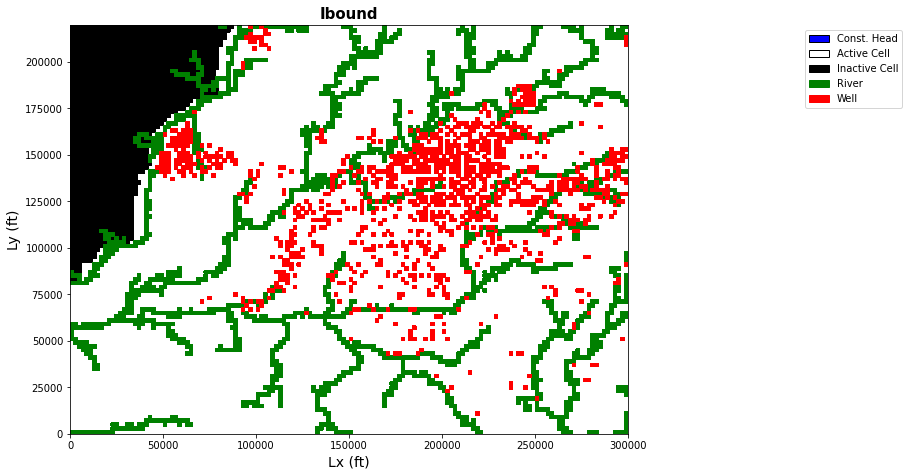

In [214]:
'''Plot grid and boundary conditions'''
#----------------------------------------------------------------------------
plt.figure(figsize=(10,10)) #create 10 x 10 figure
modelmap = flopy.plot.PlotMapView(model=m, layer=0)
#grid = modelmap.plot_grid()
ib = modelmap.plot_ibound()
rvr = modelmap.plot_bc(ftype='RIV')
wel = modelmap.plot_bc(ftype='WEL', plotAll = True)

#add labels and legend
plt.xlabel('Lx (ft)',fontsize = 14)
plt.ylabel('Ly (ft)',fontsize = 14)
plt.title('Ibound', fontsize = 15, fontweight = 'bold')
plt.legend(handles=[mp.patches.Patch(color='blue',label='Const. Head',ec='black'),
                    mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                    mp.patches.Patch(color='black',label='Inactive Cell',ec='black'),
                    mp.patches.Patch(color='green',label='River',ec='green'),
                    mp.patches.Patch(color='red',label='Well',ec='red')],
                    bbox_to_anchor=(1.5,1.0))
#----------------------------------------------------------------------------

Text(0.5, 1.0, 'Top Elevation (ft AMSL)')

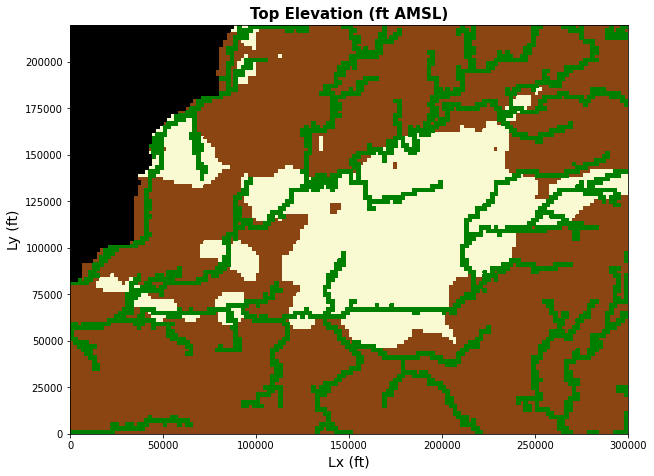

In [215]:
'''Plot elevation'''
#----------------------------------------------------------------------------
plt.figure(figsize=(10,10)) #create 10 x 10 figure
modelmap = flopy.plot.map.PlotMapView(model=m, layer=0) #use plotmapview to attach plot to model
#contour_levels = np.linspace(400,800,41)
#topelevations = modelmap.contour_array(topgrid, levels = contour_levels) #create head contours
#plt.clabel(topelevations, inline=True,fontsize=12,fmt='%1.0f')

#create colormap of named colors
colors = ["saddlebrown","lightgoldenrodyellow"]
cmap = mp.colors.LinearSegmentedColormap.from_list("", colors)
norm = mp.colors.LogNorm(vmin=kf,vmax=kc)
modelmap.plot_array(khlayers[0],norm = norm,cmap=cmap)
rvr = modelmap.plot_bc(ftype='RIV')
ib = modelmap.plot_ibound()
#display parameters
plt.xlabel('Lx (ft)',fontsize = 14)
plt.ylabel('Ly (ft)',fontsize = 14)
plt.title('Top Elevation (ft AMSL)', fontsize = 15, fontweight = 'bold')

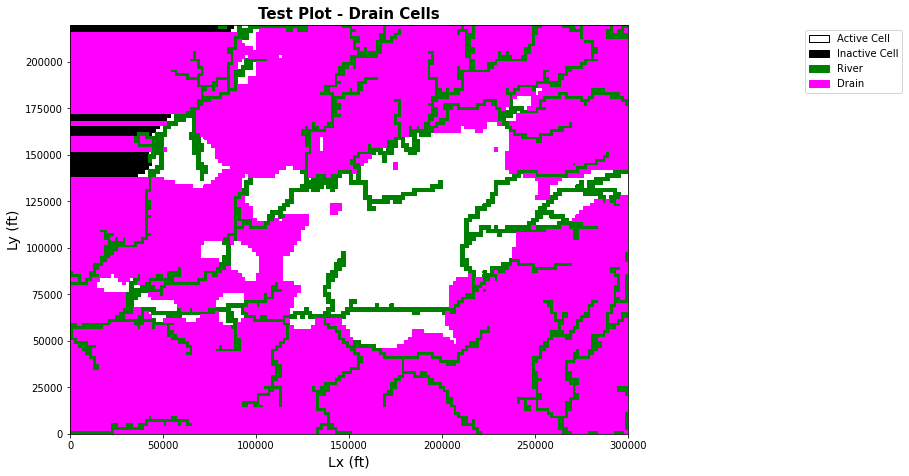

In [216]:
'''Verify that the drain cells work as intended'''
# Check that the locations of drain cells in the map below (magenta) match the locations of low-k material at land surface in the map above (dark brown)
# Additionally, check that the river cells appear in the map below, to ensure that they were not overwritten as drain cells.

#----------------------------------------------------------------------------
plt.figure(figsize=(10,10)) #create 10 x 10 figure
modelmap = flopy.plot.PlotMapView(model=m, layer=0)
#grid = modelmap.plot_grid()
ib = modelmap.plot_ibound()
rvr = modelmap.plot_bc(ftype='RIV')
drain = modelmap.plot_bc(ftype='DRN',color='magenta')

#add labels and legend
plt.xlabel('Lx (ft)',fontsize = 14)
plt.ylabel('Ly (ft)',fontsize = 14)
plt.title('Test Plot - Drain Cells', fontsize = 15, fontweight = 'bold')
plt.legend(handles=[mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                    mp.patches.Patch(color='black',label='Inactive Cell',ec='black'),
                    mp.patches.Patch(color='green',label='River',ec='green'),
                    mp.patches.Patch(color='magenta',label='Drain',ec='magenta')],
                    bbox_to_anchor=(1.5,1.0))
plt.show()

In [217]:
np.array(khlayers).shape

(10, 110, 150)

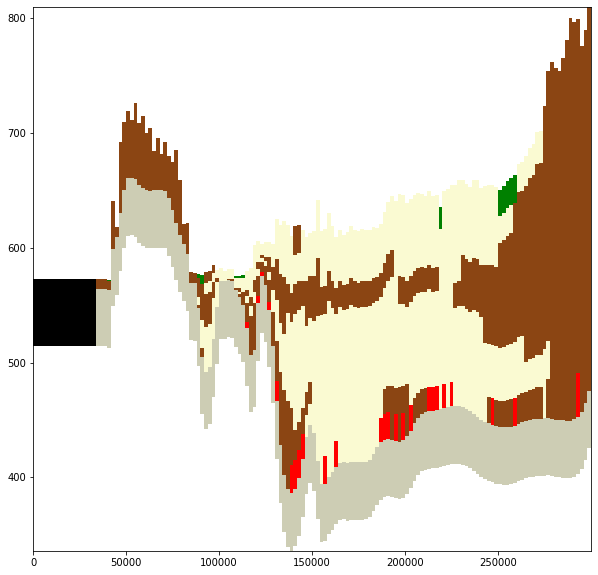

In [218]:
plt.figure(figsize=(10,10)) #create 10 x 10 figure
modelxsect = flopy.plot.PlotCrossSection(model = m, line={"row":50}) #use plotmapview to attach plot to model
#modelxsect = flopy.plot.PlotCrossSection(model = m, line={"column":100})
#create colormap of named colors
colors = ["saddlebrown","gray","lightgoldenrodyellow"]
cmap = mp.colors.LinearSegmentedColormap.from_list("", colors)
norm = mp.colors.LogNorm(vmin=kf,vmax=kc)
#modelxsect.plot_grid()
khlaynp = np.array(khlayers)
lines = modelxsect.plot_array(khlaynp,norm=norm, cmap=cmap)
rvr = modelxsect.plot_bc(ftype='RIV')
wel = modelxsect.plot_bc(ftype='WEL')
modelxsect.plot_ibound()

# 4 Write and run the MODFLOW model

In [219]:
# Write the model input
m.write_input()
# Execute the model run
success, mfoutput = m.run_model(pause=False, report=True)
# Report back if the model did not successfully complete
if not success:
    raise Exception('MODFLOW did not terminate normally.')

FloPy is using the following  executable to run the model: /usr/local/bin/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: my_model.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2020/05/03  6:36:14

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2020/05/03  6:36:34
 Elapsed run time: 19.202 Seconds

  Normal termination of simulation


# 5 Plot Output Data

In [0]:
'''Extract binary data from head and flow files'''
#----------------------------------------------------------------------------
#extract binary data from head file as flopy head object
headobj = flopy.utils.binaryfile.HeadFile(modelname+'.hds')
#extract head data from head object
head = headobj.get_data(totim=1.0)

Text(0.5, 1.0, 'Steady-State Model, Flow(ft^3/d) and Head(ft) Results')

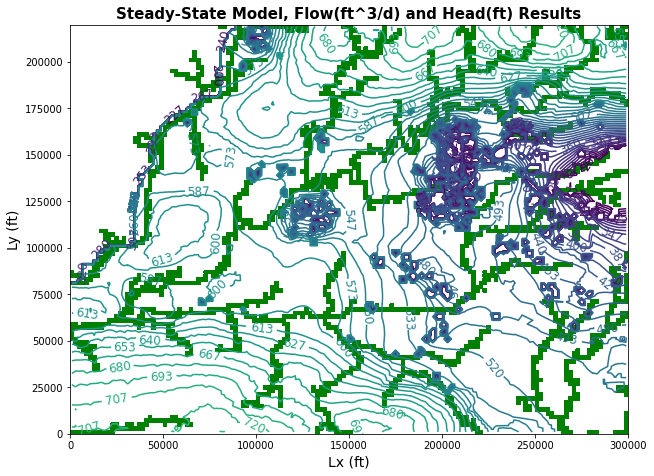

In [221]:
'''Plot results'''
#----------------------------------------------------------------------------
plt.figure(figsize=(10,10)) #create 10 x 10 figure
modelmap = flopy.plot.map.PlotMapView(model=m, layer=0) #use plotmapview to attach plot to model
#grid = modelmap.plot_grid() #plot model grid
#contour_levels = np.linspace(head[0].min(),head[0].max(),11) #set contour levels for contouring head
contour_levels = np.linspace(200,1000,61) #set contour levels for contouring head
head_contours = modelmap.contour_array(head[8], levels=contour_levels) #create head contours
plt.clabel(head_contours, inline=True,fontsize=12,fmt='%1.0f')
rvr = modelmap.plot_bc(ftype='RIV')

#display parameters
plt.xlabel('Lx (ft)',fontsize = 14)
plt.ylabel('Ly (ft)',fontsize = 14)
plt.title('Steady-State Model, Flow(ft^3/d) and Head(ft) Results', fontsize = 15, fontweight = 'bold')